In [6]:
%pylab inline
import tensorflow as tf
import tensorflow_probability as tfp

Populating the interactive namespace from numpy and matplotlib


In [7]:
tfd = tfp.distributions
tfb = tfp.bijectors
tfl = tf.keras.layers

In [8]:
from lib.SBIGaussian import *
from lib.GaussianMixture import *

### Model construction
The following classes define the data generation process of a simple neural field model. Later the bias (NF2D.bias) will be reparametrised to a 4d-vector and regarded as our model parameters.

In [24]:
class BLNoise:
    """This generates smooth noise in space and time"""
    def __init__(self, in_size, out_size, name=None):
        self.in_size = in_size
        self.out_size = out_size
        Z_init = tf.complex(
            tf.random.normal(self.in_size),
            tf.random.normal(self.in_size))
        self.Z = tf.Variable(Z_init, name='Z')

    def __call__(self):
        nt, nx, ny = self.in_size
        nT, nX, nY = self.out_size
        Z_ = tf.pad(self.Z, [(0, nT-nt),(0, nX-nx),(0, nY-ny)])
        z = tf.math.real(tf.signal.fft3d(Z_))
        return z

In [25]:
class NF2D:
    """This solves our field equation numerically and applies the noise generated above"""
    def __init__(self, nt, nlat, nlon, dt: float=0.1, name=None):
        self.local_coupling = None
        self.dt = dt
        self.sqrt_dt = tf.sqrt(dt)
        self.half_dt = dt / 2
        self.nT, self.nlat, self.nlon = nt, nlat, nlon
        
        # diffusion kernel, could replace (or train!)
        K = np.c_[:self.nlat]*np.r_[:self.nlon]
        K = K / K.max()
        
        self.kernel = tf.convert_to_tensor(K.astype(np.complex64))
        self.bias = tf.zeros((self.nlat, self.nlon))
        self.weight = tf.constant(1.0)
        self.sigma = tf.constant(0.2)
    
    def __call__(self, zs):
        xs = [zs[0]*0 - 2.0]
        for t in range(1, self.nT):
            xs.append(self._heun(xs[-1], zs[t - 1]))
        return tf.stack(xs)
    
    def _euler(self, x, z):
        "Stochastic Euler method for diff eq _f."
        z_ = z * self.sqrt_dt * self.sigma
        dx1 = self._f(x)
        return x + self.dt*dx1 + z_
    
    def _heun(self, x, z):
        "Stochastic Heun method for diff eq _f."
        z_ = z * self.sqrt_dt * self.sigma
        dx1 = self._f(x)
        dx2 = self._f(x + self.dt * dx1 + z_)
        return x + self.half_dt*(dx1 + dx2) + z_

    def _f(self, x):
        "Bistable neural field with spatial bias."
        return x - x**3/3 + self.weight*self._lc(x) + self.bias
    
    def _lc(self, x):
        "Local field coupling w/ a kernel."
        X = tf.signal.fft2d(tf.cast(x, tf.complex64))
        cx = tf.signal.ifft2d(self.kernel * X)
        return tf.math.real(cx)

In [26]:
class LobeForward:
    """This enables us to extragt EEG-like data out ouf our neural field"""
    
    def __init__(self, nlat, nlon, name=None):
        self._init_lobe_geometry(nlat, nlon)
        self._init_contact_geometry()
        self._init_lobe_normals()
        self._init_gain_matrix()

    def _init_lobe_geometry(self, nlat, nlon):
        t = np.r_[:2*np.pi:1j*nlat]
        r = np.tanh(np.sin(6*t)*2)+2
        x, z = r*np.sin(t), r*np.cos(t)
        y = np.r_[x.min():x.max():1j*nlon]
        fxyz = np.zeros((nlat, nlon, 3))
        fxyz[..., 0] = x[:,None]
        fxyz[..., 1] = y
        fxyz[..., 2] = z[:,None]
        self.fxyz = fxyz
        self.x, self.y, self.z = x, y, z
    
    def _init_contact_geometry(self):
        # TODO update later
        cy = [-2, 1, -1, 2]
        cz = [2, 1, -1, -2]
        nc = 10
        cx = np.r_[self.x.min():self.x.max():1j*nc]
        o10 = np.ones(nc)
        cxyz = np.vstack([np.c_[cx, o10*cy_, o10*cz_] for cy_, cz_ in zip(cy,cz)])
        cx, cy, cz = cxyz.T
        self.cxyz = cxyz
        
    def _init_lobe_normals(self):
        def vd(x):
            dx = np.diff(x)
            return np.r_[(dx[0] + dx[-1])/2, (dx[1:]+dx[:-1])/2, (dx[0] + dx[-1])/2]
        dx = vd(self.x)
        dz = vd(self.z)
        self.nxy = np.c_[-dz, dx]

    def _init_gain_matrix(self):
        gain = np.zeros(self.fxyz.shape[:-1] + self.cxyz.shape[:1])
        Q = np.zeros_like(self.fxyz)
        Q[..., 0] = self.nxy[:,0][:,None]
        Q[..., 2] = self.nxy[:,1][:,None]
        for i, c in enumerate(self.cxyz):
            rr0 = c - self.fxyz
            gain[..., i] = np.sum(Q * rr0, axis=-1)
            gain[..., i] /= 1e-1 + np.linalg.norm(rr0, axis=-1)**3 # 4 pi sigma
        # permute axes for perf
        # (lat, lon, contact) -> (contact, lat*lon)
        gain = np.transpose(gain, (2, 0, 1)).reshape((len(self.cxyz), -1))
        # NB: transpose now because unlike numpy, tf.tranpose is O(n)
        self.gain = tf.convert_to_tensor(gain.astype('f').T)

    def __call__(self, xt):
        xt_ = tf.reshape(xt, (-1, fwd.gain.shape[0]))  # O(1)
        return tf.linalg.matmul(xt_, self.gain)

## Model Definition

In [27]:
nt, nlat, nlon = 64, 32, 32    #number of timesteps to simulate, width, height
fwd = LobeForward(nlat, nlon)  #neural field to EEG mapping

### Model Reparametrisation:

instead of the entire bias, shape = (nlat, nlot) wich is too big, we reparametrise the bias by the coordinates, the radius and the deviation of a pathological blob. The rest is normal distributed:

In [28]:
#shape(param) = (4,)
def get_bias(param):
    """This is the bias reparametrisation"""
    x = tf.math.sigmoid(param[0]) * nlat
    y = tf.math.sigmoid(param[1]) * nlon
    r = param[2] ** 2
    depth = param[3]
    
    bias = np.random.randn(nlat, nlon) / 10
    
    def fill(x_,y_):
        r2 = (x_-x)**2 + (y_-y)**2
        return np.exp(-r2/(r+0.01)) * depth
        
        
    overlay = np.fromfunction(fill, shape = (nlat, nlon))
    
    return tf.constant(bias + overlay)

In [29]:
def mech_model(theta):
    """This allows us to sample from our model with given model parameters"""
    noise = BLNoise((16, 4, 4), (nt, nlat, nlon))()
    nf = NF2D(nt, nlat, nlon)
    nf.bias = get_bias(theta)
    data = nf(noise)
    y = fwd(data)
    
    return y

### Example

<Figure size 432x288 with 0 Axes>

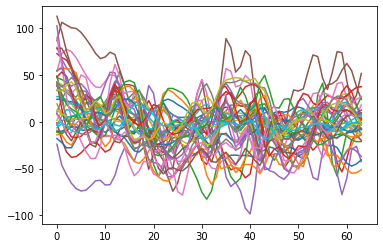

<Figure size 432x288 with 0 Axes>

In [36]:
data = mech_model(tf.constant([0.,0.,5,5]))
plt.plot(data)
plt.figure()

## Dataset
We first created a big dataset (sample from the joint distribution $P(x;\theta)$) and saved it to the hard drive. Later it can be reloaded and resampling is not needed for different trainig approaches -> faster

In [41]:
proposal_prior = tfd.Normal(loc = [0,0,9,8], scale = [1,1,1,1]) #the prior distribution of parameters

In [42]:
# N = 1e4
# def data_gen():
#     for i in range(int(N)):
#         theta = proposal_prior.sample()
#         s = mech_model(theta)
        
#         if i % (int(N)/1000) == 0:
#             print(i/N)
        
#         yield s, theta


# dataset = tf.data.Dataset.from_generator(data_gen, output_signature = (tf.TensorSpec(shape = (nt, 40)), tf.TensorSpec(shape = (4,))))

# tf.data.experimental.save(dataset, "data/MinFieldData_prior_mean_0_0_9_8_std_1_1_1_1")

In [43]:
dataset = tf.data.experimental.load("data/MinFieldData_prior_mean_0_0_9_8_std_1_1_1_1")

In [44]:
dataset = dataset.batch(100)

## Feature Extractor
This is a preprocessing step. It takes in the output of the model, wich are multiple (40x) time-series of length $nt$. This is fed through an LSTM and 3 Dense layers to create a compressed representation

In [45]:
compressed_dim = 140

In [46]:
class Compressor(tf.Module):
    def __init__(self, name = None):
        super().__init__(name = name)
        self.lstm1 = tfl.LSTM(units = 616)
        self.d1 = tfl.Dense(units = 240, activation = "relu")
        self.d2 = tfl.Dense(units = 200, activation = "relu")
        self.d3 = tfl.Dense(units = compressed_dim, activation = "relu")
    
    @tf.function()
    def __call__(self, batch):
        x = self.lstm1(batch)
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        return x

## Variational Distribution

In [47]:
#things to train:


#Variational Posterior Distribution. This makes use of our libray.
#It represents a gaussian mixture distribution over the parameter space (param_dim = 4)
#It is conditioned on data (data_dim = compressed_dim) wich is the output of our model
#The compressed data is fed through multiple densely connected layers (layer_sizes = [120,120,120])
#wich each output the categorical logits, the means and the variances of our posterior distribution
variational_dist = SBIGaussianMixture(data_dim = compressed_dim, param_dim = 4, n_components = 1, layer_sizes = [120,120,120])

#This is the data-preprocessor defined above
compressor = Compressor()

In [48]:
#This calculates the likelihood of a batch of data and parameters with respect to our posterior distribution:
@tf.function()
def logp(batch_data, batch_theta):
    compressed = compressor(batch_data)
    val = tf.reduce_sum(variational_dist.log_prob(compressed, batch_theta))
    return val

#Loss function to optimize wrt. to parameters of compressor and variational_dist
@tf.function()
def loss(batch_data, batch_theta):
    return -logp(batch_data, batch_theta)

In [18]:
opt = tf.optimizers.Adam(learning_rate = 0.01)
metrics = {"loss": []}

In [102]:
for i in range(6):
    for batch in dataset:
        batch_x, batch_theta = batch

        def loss_():
            val = loss(batch_x, batch_theta)
            metrics["loss"].append(val.numpy())
            return val
        opt.minimize(loss_, variational_dist.trainable_variables + compressor.trainable_variables)

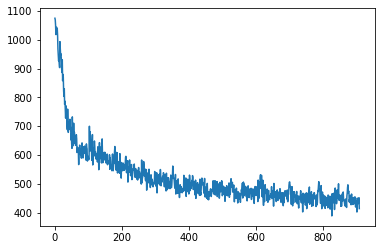

In [103]:
plt.plot(metrics["loss"][20:])

## Observation
Now we can make a "real" observation. For this we sample from our prior and generate according data. Then we use this data to generate our trained posterior distribution. We sample from it (blue datapoints) and also visualise the position of the originally used parameters from our prior (orange).

Furthermore, we visualise both bias fields, one resulting out of our used parameters and the maximum-likelihood one in accordance to our posterior distribution. They should be similar.

In [114]:
theta = proposal_prior.sample()
used_bias = get_bias(theta)


obs = mech_model(theta)
post_dist = variational_dist.build_dist(compressor(tf.expand_dims(obs, axis = 0)))
post_dist_param = variational_dist.calc_mixture_params(compressor(tf.expand_dims(obs, axis = 0)))
post_sample = post_dist.sample(1000)

<Figure size 432x288 with 0 Axes>

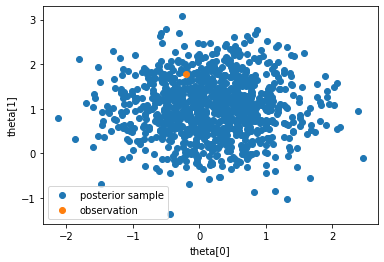

<Figure size 432x288 with 0 Axes>

In [115]:
plt.scatter(post_sample[:,0,0], post_sample[:,0,1], label = "posterior sample")
plt.scatter(theta[0], theta[1], label = "observation")
plt.xlabel("theta[0]")
plt.ylabel("theta[1]")
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

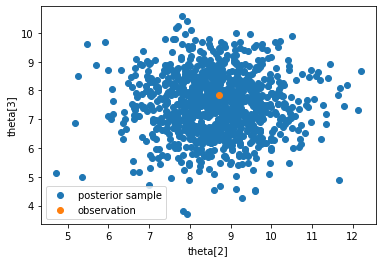

<Figure size 432x288 with 0 Axes>

In [116]:
plt.scatter(post_sample[:,0,2], post_sample[:,0,3], label = "posterior sample")
plt.scatter(theta[2], theta[3], label = "observation")
plt.xlabel("theta[2]")
plt.ylabel("theta[3]")
plt.legend()
plt.figure()

Text(0.5, 1.0, 'Mean posterior Bias')

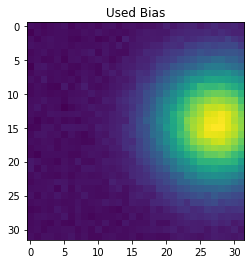

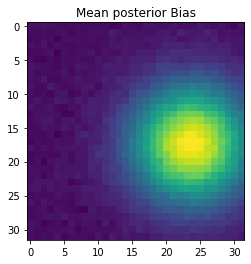

In [117]:
plt.imshow(used_bias)
plt.title("Used Bias")
plt.figure()

plt.imshow(get_bias(post_dist_param[1][0][0]))
plt.title("Mean posterior Bias")

## Save Model Params

In [108]:
chkp_path = "checkpoints/compressor/"
checkpoint = tf.train.Checkpoint(model=compressor)
checkpoint.write(chkp_path)

'checkpoints/compressor/'

In [109]:
chkp_path = "checkpoints/variational_dist/"
checkpoint = tf.train.Checkpoint(model=variational_dist)
checkpoint.write(chkp_path)

'checkpoints/variational_dist/'